# Problem 5.1
Attributions: Shashank did a,b, and c; Michelle did d; Elena did e; Elena and Shashank did f.

Before we do anything else, we load the necessary modules and read in the `DataFrame`.

In [33]:
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

#import stat tools
import numdifftools as ndt
import scipy.stats as st

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data
df = pd.read_csv('./data/mean_rest_bouts.csv', comment='#')

# Pull out wild type and mutant and take NaNs to be zero
df = df[df['genotype'].isin(['wt', 'mut'])].fillna(0)

# Part A
Sample mean is the best estimate of $\mu$. Unbiased estimator of variance is:
\begin{align}
\frac{n}{n-1}&s^2
\end{align}

In [34]:
def get_estimates(data):
    """
    Takes a tidy dataframe as an input. Returns:
    1. mu_wt
    2. mu_mut
    3. sigma_wt
    4. sigma_mut
    """
    # separate the dataset into wild type and mutant
    wt_fish = data[data["genotype"]=="wt"]
    mut_fish = data[data["genotype"]=="mut"]

    # find means for wt and mut
    mu_wt = float(wt_fish.mean())
    mu_mut = float(mut_fish.mean())

    # find unbiased estimator of variance for wt and mut
    sigma_wt = float(np.sqrt(wt_fish.var(ddof=1)))
    sigma_mut = float(np.sqrt(mut_fish.var(ddof=1)))

    # return values
    return mu_wt, mu_mut, sigma_wt, sigma_mut

# part a

mu_wt, mu_mut, sigma_wt, sigma_mut = get_estimates(df)

print("""The best estimates for µ and σ are:
                µ           σ
             -----------------
    WT       {0:.4f}     {2:.4f}
    Mutant   {1:.4f}     {3:.4f}
    """.format(mu_wt, mu_mut, 
           sigma_wt, sigma_mut))

The best estimates for µ and σ are:
                µ           σ
             -----------------
    WT       2.2094     0.5229
    Mutant   1.7271     0.8051
    


In [35]:
def cohen_d(data):
    """
    Cohen's d
    """
    # separate the dataset into wild type and mutant
    w = data[data["genotype"]=="wt"]
    m = data[data["genotype"]=="mut"]
    
    w_s = w.var(ddof=1)
    m_s = m.var(ddof=1)
    
    sd = ((len(w)-1) * w_s + (len(m) - 1) * m_s) / (len(w) + len(m) - 2)
    
    diff = m.mean() - w.mean()

    cohen = np.abs(diff) / np.sqrt(sd)
    
    return float(cohen)

effect_size = cohen_d(df)

print ('Effect size = {0:.4f}'.format(effect_size))

Effect size = 0.6918


# Part B

Frequentist estimate of the difference of the means:
\begin{align}
\delta \equiv \mu_{wt} - \mu_{mut}
\end{align}

In [52]:
def get_frequentist_estimate(mu_wt, sigma_wt, mu_mut, sigma_mut, data, trials=10000):
    """
    Returns frequentist estimate of the difference of the mean with a 95%
    confidence interval. Takes as input the result of get_estimates 
    function defined in part a.
    """
   
    # separate the dataset into wild type and mutant
    wt_fish = data[data["genotype"]=="wt"]
    mut_fish = data[data["genotype"]=="mut"]
    
    def difference_of_means(mu_wt, sigma_wt, mu_mut, sigma_mut, reps_wt, reps_mut, trials):
        """
        This function draws samples out of a gaussian distribution defined for wildtype
        and mutant population using means and sigmas calculated in part a.
        """
        difference_mean_holder = np.empty(trials)
    
        for i in range(trials):
            wt_rep_mean = np.random.normal(mu_wt, sigma_wt, reps_wt).mean()
            mut_rep_mean = np.random.normal(mu_mut, sigma_mut, reps_mut).mean()
            difference_mean_holder[i] = wt_rep_mean - mut_rep_mean
        
        return difference_mean_holder
    
    difference_out = difference_of_means(mu_wt, sigma_wt, mu_mut, sigma_mut, 
                                         len(wt_fish), len(mut_fish), trials)
    
    frequentist_lowCI, frequentist_highCI = np.percentile(difference_out, (2.5,97.5))
    return float(mu_wt - mu_mut), float(1.96*np.std(difference_out)), float(frequentist_lowCI),\
float(frequentist_highCI)

# unpack results
frequentist_estimate, confidence_interval, frequentist_lowCI, frequentist_highCI = \
get_frequentist_estimate(mu_wt, sigma_wt, mu_mut, sigma_mut, df, 10000)

print("""The frequentist estimate of the difference of the mean is:
      µ(wt)-µ(mut) = {0:.4f} ± {1:.4f}"""
      .format(float(frequentist_estimate), confidence_interval), "minutes")

The frequentist estimate of the difference of the mean is:
      µ(wt)-µ(mut) = 0.4823 ± 0.4126 minutes


# Part C

In [37]:
def get_bayesian_estimate(data):
    """
    This function takes the dataframe containing wildtype and mutant fish and
    calculates the bayesian estimate for the difference of the means.
    """
    # separate the dataset into wild type and mutant
    wt_fish = data[data["genotype"]=="wt"]
    mut_fish = data[data["genotype"]=="mut"]
    
    # Define log of the posterior
    def log_post(p, x_wt, x_mut):
        """
        Returns the log of the posterior consisting of the product of Gaussians.
        p[0] = mu_wt
        p[1] = mu_mut
        p[2] = sigma_wt
        p[3] = sigma_mut
        """
        # Unpack parameters
        mu_wt, mu_mut, sigma_wt, sigma_mut = p
    
        # Make sure we have everything in the right range
        if (sigma_wt < 0) or (sigma_mut < 0):
            return -np.inf

        # Compute separate parts of posterior from each sample
        log_post_wt = st.norm.logpdf(x_wt, mu_wt, sigma_wt).sum() - np.log(sigma_wt)
    
        log_post_mut = st.norm.logpdf(x_mut, mu_mut, sigma_mut).sum() - np.log(sigma_mut)

        # Add them up to return
        return log_post_wt + log_post_mut

    def negative_log_post(p, x_wt, x_mut):
        
        return -log_post(p, x_wt, x_mut)

    # MAP
    wt = wt_fish[("mean_rest_bout_length")]
    mut = mut_fish[("mean_rest_bout_length")]
    
    # define args
    args = (wt, mut)
    p0 = np.array([ 2, 1.5, 0.5, 0.8])

    hes_fun = ndt.Hessian(log_post)
    res = scipy.optimize.minimize(negative_log_post, p0, args=args)
    hes = hes_fun(res.x,wt,mut)
    cov = -np.linalg.inv(hes)

    bayesian_estimate_diff = res.x[0] - res.x[1]
    credible_interval = 1.96 * np.sqrt(np.sqrt(cov[0,0])**2 + np.sqrt(cov[1,1])**2)
    
    lowCI, highCI = np.percentile(bayesian_estimate_diff, (2.5, 97.5))
    
    return float(bayesian_estimate_diff), float(credible_interval), cov, float(res.x[0]), float(res.x[1]), \
float(res.x[2]), float(res.x[3]), float(lowCI), float(highCI)

bayesian_estimate, credible_interval, covariance, wt_mu_map, mut_mu_map, wt_sigma_map, mut_sigma_map, \
bayesian_lowCI, bayesian_highCI = get_bayesian_estimate(df)

print("""The Bayesian estimate of the difference of the mean is:
    µ(wt)-µ(mut) = {0:.4f} ± {1:.4f}""".format(bayesian_estimate, credible_interval), "minutes.")

The Bayesian estimate of the difference of the mean is:
    µ(wt)-µ(mut) = 0.4823 ± 0.3978 minutes.


In [38]:
np.percentile(bayesian_estimate, ([2.5,97.5]))

array([ 0.48233546,  0.48233546])

# Part D

Now we want to test our null hypothesis. $H_0$ is that the wild type and mutant are drawn from the same Gaussian distribution, more specifically a student-t distribution. In other words that the means are the same $\mu_{wt} = \mu_{mut}$. 

We can use a T-statistic as our measurable statistic. 
\begin{align}
T = \frac {\bar{x}_1 - \bar{x}_2 - n_1 + n_2} {S_D \sqrt{n^{-1}_1 + n^{-1}_2}}
\end{align}
Where $S_D$ is defined as:
\begin{align}
S_D = \frac {(n_1 - 1)S_1^2 + (n_2 - 1)S_2^2} {n_1 + n_2 -2}
\end{align}
And $S_1$ and $S_2$ are
\begin{align}
S = \frac {1}{n - 1} \sum_{i \in D}{(x_i - \bar{x})^2}
\end{align}
for their respective values.

We want to combine all of our measurements and then redistribute them to a group of 17 and group of 22 and we want to do this over and over again. 

In [39]:
# our null hypothesis is that the mutant and the wild type are drawn from the same
# Gaussian distribution in other words we want to test if the mutant mean is the same
# as the wt mean

# We first combine all of the measurements and then distrbute them to a set of 17 and 
# a set of 22

def final_p_value(data, trials=10000, greater_or_less='greater', return_abs=False):
    
    #separate the dataset in to wild type and mutant
    wt_fish = data[data["genotype"]=="wt"]
    mut_fish = data[data["genotype"]=="mut"]
    
    # we want to make an array of the mean rest bout lengths
    w = wt_fish['mean_rest_bout_length'].values
    m = mut_fish['mean_rest_bout_length'].values
    
    def distribute_samples(w, m, some_func, trials, args=()):
        '''
        combine our measurements for rest bout and redistribute them to two groups
        '''
    
        # first we create an empty array to store our samples
        samples = np.empty(trials)
    
        # concatenate all the measurements
        measurements = np.concatenate((w, m))
    
        # create sets for all trials 
        for i in range(trials):
            measurements = np.random.permutation(measurements)
            samples[i] = some_func(measurements[:len(w)], measurements[len(w):], *args)
     
        return samples


    # now we define the p-value
    def p_value(samples, actual, greater_or_less='greater'):
        '''
        compute the p value (the probability our measurement is 
        greather than or less than the actual value
        '''
    
        if greater_or_less == 'greater':
            return float(np.sum(samples >= actual) / len(samples))
        else:
            return float(np.sum(samples <= actual) / len(samples))

    # now we can run our test and see if we will get the actual difference in our means
    # this will be my some_func in my distribute_samples function
    
    def T_stat(w, m, return_abs=False):
        '''
        Calculate the absolute difference of the means
        '''
        w_s = w.var(ddof=1)
        m_s = m.var(ddof=1)
    
        sd = ((len(w)-1) * w_s**2 + (len(m) - 1) * m_s**2) / (len(w) + len(m) - 2)
    
        diff = w.mean() - m.mean() - np.sqrt(w.var()) + np.sqrt(m.var()) 
        pool_variance = sd * np.sqrt(1/(len(w)) + 1/(len(m)))
            
        if return_abs:
            return float(np.abs(diff) / pool_variance   )
        return float(diff / pool_variance)


    # let's retrieve all our random sample sets of two
    samples = distribute_samples(w, m, T_stat, trials, args = (True,))

    # calculate p value
    p_value_student_t = p_value(samples, T_stat(w, m))

    return float(p_value_student_t)

p_value = final_p_value(df, 10000)

print("Welch's t test p value =", p_value)

Welch's t test p value = 0.0219


In [40]:
p_value

0.0219

# Part E

The odds ratio is given by:

\begin{align}
O_{01} \approx \left(\frac{P(H_0\mid I)}{P(H_1\mid I)}\right)
\left(\frac{P(D\mid \mu^*, \sigma^*, H_0, I)}{P(D\mid \mu^*_w, \mu^*_m, \sigma^*_w, \sigma^*_m, H_1, I)}\right)
\left(\frac{P(\mu^*, \sigma^* \mid H_0, I) \,2\pi\,\sqrt{\det\boldsymbol{\sigma_0^2}}}
{P(\mu^*_w, \mu^*_m, \sigma^*_w, \sigma^*_m \mid H_1, I)\,(2\pi)^{2} \sqrt{\det\boldsymbol{\sigma}_1^2}}\right),
\end{align}

In this case, $H_0$ is the hypothesis that wild type and mutant are drawn from the same Gaussian distribution, while $H_1$ is the hypothesis that they are drawn from different Gaussian distributions with their own means and variances.

First we define functions to calculate the log posterior and covariance matrix for $H_0$. (We have already done these calculations for $H_1$ in part (c)). Recall that the posterior for a Gaussian distribution is as follows:

\begin{align}
P(\mu, \sigma \mid D, I) \propto\frac{1}{\sigma^{n+1}}
\exp\left[-\frac{1}{2\sigma^2}\sum_{i\in D}(x_i - \mu)^2\right].
\end{align}

And for the covariance matrix, we note that the MAPs we need to put into the Hessian function are simply our best estimates of the sample mean and standard deviation. 

In [41]:
def log_post_H0(p, x):
    """
    Returns the log of the posterior for a Gaussian.
    p[0] = mu
    p[1] = sigma
    """
    # Unpack parameters
    mu, sigma = p

    # Make sure we have everything in the right range
    if (sigma < 0):
        return -np.inf

    # Add them up to return
    output = float(st.norm.logpdf(x, mu, sigma).sum() - np.log(sigma))

    return output

def cov_H0(p, x):    
    """
    Calculates the covariance matrix for H_0
    """
    # Instantiate Hessian for log posterior for H_0
    hes_fun = ndt.Hessian(log_post_H0)

    # Compute Hessian at MAP for H_0
    hes = hes_fun(p, x)
    cov = -np.linalg.inv(hes)

    return cov

Next, we set up the functions to compute the log of the goodness of fit ratio and the log of the Occam factor. Note that for the Occam factor, the ratio of the priors is not unity, but rather $\frac{\sigma_w \sigma_m}{\sigma}$ since we have Jeffreys priors for each $\sigma$.

In [ ]:
def log_good_fit_ratio(p, x, wt_mut, wt_mu_map, wt_sigma_map, mut_mu_map, mut_sigma_map): 
    """
    Calculates the log of the goodness of fit ratio
    """
    # Unpack parameters
    mu, sigma = p

    ratio_output = st.norm.logpdf(x, mu, sigma).sum() \
- st.norm.logpdf(wt_mut[0], wt_mu_map, wt_sigma_map).sum() \
- st.norm.logpdf(wt_mut[1], mut_mu_map, mut_sigma_map).sum()

    return float(ratio_output)

def log_occam(p, x, wt_sigma_map, mut_sigma_map, cov):
    """
    Calculates the log of the Occam factor
    """
    # Unpack parameters
    mu, sigma = p

    return np.log(wt_sigma_map) + np.log(mut_sigma_map) + \
                np.log(2 * np.pi) + np.log(np.linalg.det(cov_H0(p, x)))/2 \
                - np.log(sigma) - 2 * np.log(2 * np.pi) - np.log(np.linalg.det(cov))/2

Finally we put all the parts together to get the log odds ratio, which we exponentiate before returning it from the function. 

In [42]:
def odds_ratio(data, cov, wt_mu_map, wt_sigma_map, mut_mu_map, mut_sigma_map):
    """
    This function calculates the odds ratio for H_0 and H_1.
    
    data = the dataframe with all of the wt and mut fish
    cov = the covariance matrix calculated for the joint Gaussian distribution in part (c)
    wt_mu_map = the MAP for the wild-type mu as calculated in part (c)
    wt_sigma_map = the MAP for the wild-type sigma as calculated in part (c)
    mut_mu_map = the MAP for the mutant mu as calculated in part (c)
    mut_sigma_map = the MAP for the mutant sigma as calculated in part (c)
    
    """
    # Set up additional variables to pass in as arguments to the sub-functions
    wt_fish = data[data['genotype']=='wt']
    mut_fish = data[data['genotype']=='mut']
    
    p = np.asarray([data['mean_rest_bout_length'].mean(), data['mean_rest_bout_length'].std()])
    x = data['mean_rest_bout_length']
    wt_mut = np.asarray([wt_fish['mean_rest_bout_length'], mut_fish['mean_rest_bout_length']])
          
    return float(np.exp(log_good_fit_ratio(p, x, wt_mut, wt_mu_map, wt_sigma_map, \
                                     mut_mu_map, mut_sigma_map) \
                  + log_occam(p, x, wt_sigma_map, mut_sigma_map, cov)))

o_r = odds_ratio(df, covariance, wt_mu_map, wt_sigma_map, mut_mu_map, mut_sigma_map)
print("""Odds ratio = {0:.4f}""".format(o_r))

Odds ratio = 0.0830


The odds ratio tells us that $H_1$ is a little more than 10 times more probable than $H_0$. This intuitively seems reasonable, since we calculated a moderate effect size in part (a). 

# Part F

For part (f), we generate a set of mean sleep bout lengths for 17 wild type fish and 22 mutant fish by drawing the bout lengths out of two Gaussian distributions with the means and variances we estimated in part (a). We then take the new fish and repeat parts (b) through (e) by using the functions we defined above. We do all of this 100 times.

In [54]:
def sample_data(data):
    
    wt_fish = data[data["genotype"]=="wt"]
    mut_fish = data[data["genotype"]=="mut"]

    def new_gaussian_draw(mu, std, s):
        """
        draw a sample of size s from a Gaussian distribution with mu = mu and 
        sigma = std
        """
        return np.random.normal(mu, std, s)

    new_wt_fish = wt_fish.drop('mean_rest_bout_length', axis=1)
    new_wt_fish['mean_rest_bout_length'] = new_gaussian_draw(muWT, sigmaWT, 17)
    new_mut_fish = mut_fish.drop('mean_rest_bout_length', axis=1)
    new_mut_fish['mean_rest_bout_length'] = new_gaussian_draw(muMUT, sigmaMUT, 22)
    new_fish = pd.concat((new_wt_fish, new_mut_fish), axis=0)
    
    return new_fish

pseudo_frequentist_estimate_ar = np.empty(100)
pseudo_frequentist_lowCI_ar = np.empty(100)
pseudo_frequentist_highCI_ar = np.empty(100)
pseudo_bayesian_estimate_ar = np.empty(100)
pseudo_bayesian_lowCI_ar = np.empty(100)
pseudo_bayesian_highCI_ar = np.empty(100)
pseudo_p_value_ar = np.empty(100)
pseudo_odds_ratio_ar = np.empty(100)

for i in range(100):
    
    #sample data 
    pseudo_fish_data = sample_data(df)
        
    #get estimates from part a
    pseudo_muWT, pseudo_muMUT, pseudo_sigmaWT, pseudo_sigmaMUT = \
                                                get_estimates(pseudo_fish_data)
    
    #get frequentist estimate from part b
    pseudo_frequentist_estimate, pseudo_confidence_interval, \
    pseudo_frequentist_lowCI, pseudo_frequentist_highCI = \
    get_frequentist_estimate(pseudo_muWT, pseudo_sigmaWT, 
                             pseudo_muMUT, pseudo_sigmaMUT, 
                             pseudo_fish_data)
        
    #get bayesian estimate from part c
    pseudo_bayesian_estimate, pseudo_credible_interval, \
    pseudo_covariance, pseudo_WTmuMAP, pseudo_MUTmuMAP, pseudo_WTsigmaMAP, \
    pseudo_MUTsigmaMAP, pseudo_bayesian_lowCI, pseudo_bayesian_highCI  = \
    get_bayesian_estimate(pseudo_fish_data)
        
    #get p-value from part d
    pseudo_p_value = final_p_value(pseudo_fish_data, 10000)
    
    #get odd ratios from part e
    pseudo_odds_ratio = odds_ratio(pseudo_fish_data,
                                   pseudo_covariance,
                                   pseudo_WTmuMAP,
                                   pseudo_WTsigmaMAP,
                                   pseudo_MUTmuMAP,
                                   pseudo_MUTsigmaMAP)
        
    #store all values in arrays
    pseudo_frequentist_estimate_ar[i], pseudo_frequentist_lowCI_ar[i], \
    pseudo_frequentist_highCI_ar[i], pseudo_bayesian_estimate_ar[i], \
    pseudo_bayesian_lowCI_ar[i], pseudo_bayesian_highCI_ar[i], \
    pseudo_p_value_ar[i], pseudo_odds_ratio_ar[i] = pseudo_frequentist_estimate, \
    pseudo_frequentist_lowCI, pseudo_frequentist_highCI, \
    pseudo_bayesian_estimate, pseudo_bayesian_lowCI, \
    pseudo_bayesian_highCI, pseudo_p_value, pseudo_odds_ratio 

Now we can plot the p-values, odds ratios, frequentist confidence intervals, and Bayesian credible regions to show how they danced as we repeated the experiment.

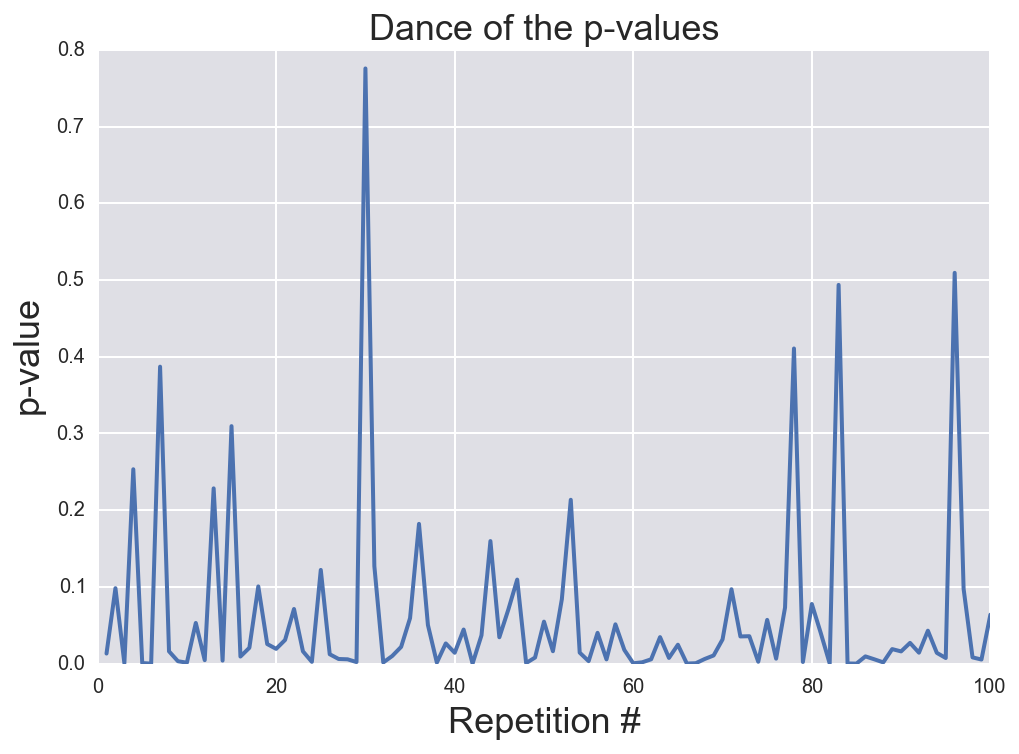

In [50]:
x=np.arange(1,101)
plt.plot(x,pseudo_p_value_ar[x-1])
plt.title("Dance of the p-values")
plt.xlabel("Repetition #")
plt.ylabel("p-value")

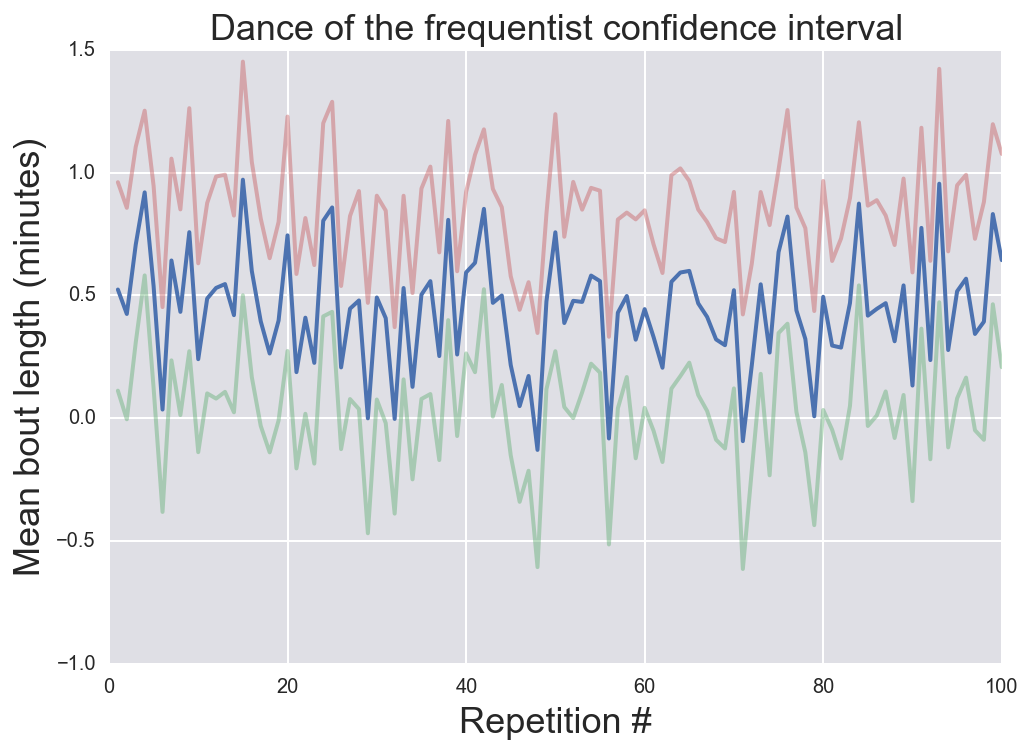

In [55]:
plt.plot(x,pseudo_frequentist_estimate_ar[x-1])
plt.plot(x,pseudo_frequentist_lowCI_ar[x-1],alpha=0.4)
plt.plot(x,pseudo_frequentist_highCI_ar[x-1],alpha=0.4)
plt.title("Dance of the frequentist confidence interval")
plt.xlabel("Repetition #")
plt.ylabel("Mean bout length (minutes)")

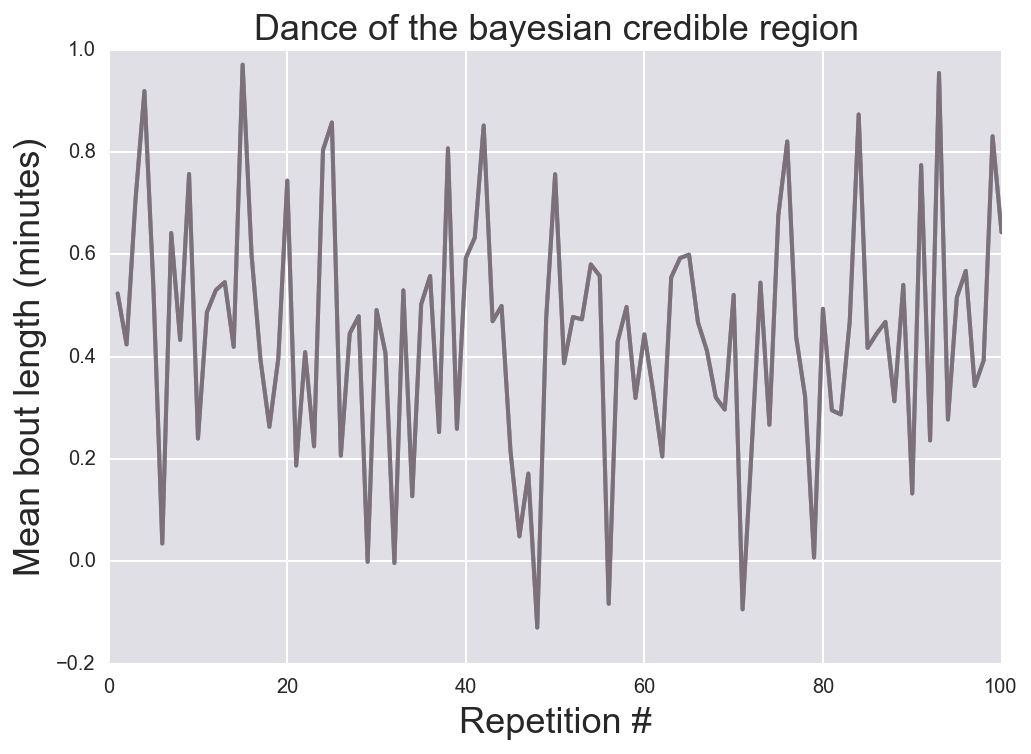

In [58]:
plt.plot(x,pseudo_bayesian_estimate_ar[x-1])
plt.plot(x,pseudo_bayesian_lowCI_ar[x-1],alpha=0.4)
plt.plot(x,pseudo_bayesian_highCI_ar[x-1],alpha=0.4)
plt.title("Dance of the bayesian credible region")
plt.xlabel("Repetition #")
plt.ylabel("Mean bout length (minutes)")

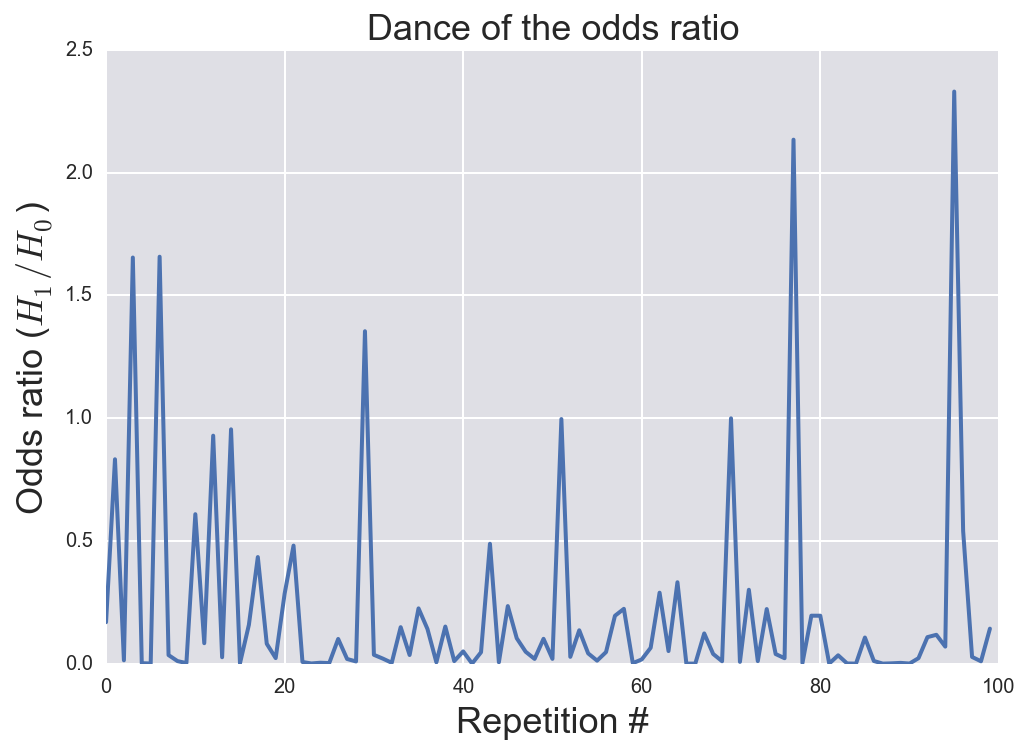

In [47]:
plt.plot(x,pseudo_odds_ratio_ar[x])

plt.title("Dance of the odds ratio")
plt.xlabel("Repetition #")
plt.ylabel("Odds ratio ($H_1/H_0$)")

We see quite a bit of variability in the p-values and odds ratios. We suspect that having a larger effect size would tend to increase the reproducibility of the p-value and odds ratio, since a large-enough effect size would mask random variability within the two populations.

We also see a lot of variability in the widths of the frequentist confidence intervals and Bayesian credible regions. However, we note that the plots for the frequentist confidence interval and Bayesian credible region look very similar, which suggests that for getting reasonable estimates for your parameters, it shouldn't matter much which approach you choose (at least for the case we have looked at here, where the sample sizes are very small). We expect that having a much larger sample size would tend to increase the reproducibility of these statistics as the larger each sample is, the smaller the sample standard deviations will be, and hence the confidence intervals (or credible regions) will be narrower and have less variation in width. 

Overall, from the above graphs, we can see that none of the statistics we calculated to describe our data are very reproducible. They vary quite a bit as we randomly draw different data sets from the Gaussian distribution defined by the best estimates of $\mu$ and $\sigma$ for our original data set. This tells us that we should not place too much faith in any one of these statistics. Just because we get a "statistically significant" p-value for one sample from a population, that does not mean that all other similarly-sized samples from the same population (i.e. repeats of the experiment) would also give us a statistically significant p-value. The same goes for getting a confidence interval (or Bayesian credible region) that has a particular width, or for getting an odds ratio less than one (or greater than one). 
